In [4]:
# Installing relevant packages
! pip install afinn
! pip install scikit-plot
! pip install umap-learn
! pip install scipy==1.11.4
! pip install surprise
! pip install xgboost

In [2]:
# Importing relevant packages
import re
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, Reader, Dataset, accuracy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV as GridSearchCV_from_sklearn

In [5]:
# Loading Data
# data = pd.read_json('/Applications/anaconda3/envs/ece143/renttherunway_final_data.json', lines=True)
data = pd.read_json('/Applications/anaconda3/envs/ece143/renttherunway_final_data.json', lines=True)
# data = pd.read_json('renttherunway_final_data.json', lines=True)

**1. Data Cleaning**



In [6]:
# Rename columns containing space character
data.rename(columns={'bust size': 'bust_size', 'rented for': 'rented_for', 'body type':'body_type'}, inplace=True)

In [7]:
# Previewing data
data.sample(5)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
147148,fit,461941,32c,1882156,118lbs,10.0,formal affair,Fit was perfect. Can't wear a bra with it; ev...,athletic,I had SO many compliments on this dress. Hand...,gown,"5' 3""",4,38.0,"April 11, 2016"
103998,fit,83630,34d,1687082,130lbs,10.0,wedding,This ran very true to size. It was a little ti...,athletic,Perfect for a summer wedding!,gown,"5' 4""",8,27.0,"August 1, 2017"
77862,small,257154,34b,2303880,140lbs,8.0,other,I wore the small but probably would have been ...,pear,"Lace, Lace, Lace",romper,"5' 10""",8,28.0,"April 1, 2015"
170546,fit,131433,34d,172027,NaN,8.0,party,The shoulders felt kind of loose and the dress...,apple,I wore this for my birthday and I absolutely f...,dress,NaN,20,28.0,"July 31, 2014"
176338,large,691468,34c,2577550,125lbs,10.0,party,"loved this! i'm only 5'3"" and this hit perfect...",full bust,unforgettable!,jumpsuit,"5' 3""",4,31.0,"May 23, 2016"


In [8]:
data.shape

(192544, 15)

In [9]:
data.item_id.count()

192544

In [10]:
# Overview of dataframe structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented_for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [11]:
# Analyze the missing data for each column
data.isna().sum()

fit                   0
user_id               0
bust_size         18411
item_id               0
weight            29982
rating               82
rented_for           10
review_text           0
body_type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [12]:
# Get the most common value in each colum
size_null = ['bust_size', 'weight', 'rented_for', 'body_type', 'height']
for i in size_null:
  i_sum = data.groupby(i).size().sort_values(ascending=False)
  print(i_sum.head(1))

bust_size
34b    27285
dtype: int64
weight
130lbs    14370
dtype: int64
rented_for
wedding    57784
dtype: int64
body_type
hourglass    55349
dtype: int64
height
5' 4"    28012
dtype: int64


1.1 Dealing with missing values



In [13]:
# Use the most common value in each column to fill missing data
data['bust_size'].fillna('34b', inplace=True)
data['weight'].fillna('130lbs', inplace=True)
data['rating'].fillna(float(data['rating'].median()), inplace=True)
data['rented_for'].fillna('wedding', inplace=True)
data['body_type'].fillna('hourglass', inplace=True)
data['height'].fillna('5\' 4"', inplace=True)
data['age'].fillna(float(data['age'].median()), inplace=True)

/var/folders/nt/t2rcl5mn1kl1k_dtq25_f1900000gn/T/ipykernel_31829/1140609766.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bust_size'].fillna('34b', inplace=True)
/var/folders/nt/t2rcl5mn1kl1k_dtq25_f1900000gn/T/ipykernel_31829/1140609766.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [14]:
# Check whether still exist missing columns
data.isna().sum()

fit               0
user_id           0
bust_size         0
item_id           0
weight            0
rating            0
rented_for        0
review_text       0
body_type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64

1.2 Data Analysis before converting type

<Figure size 1500x800 with 0 Axes>

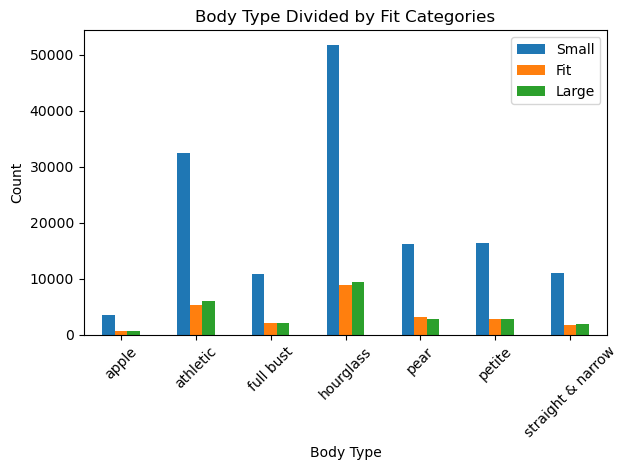

<Figure size 1200x1000 with 0 Axes>

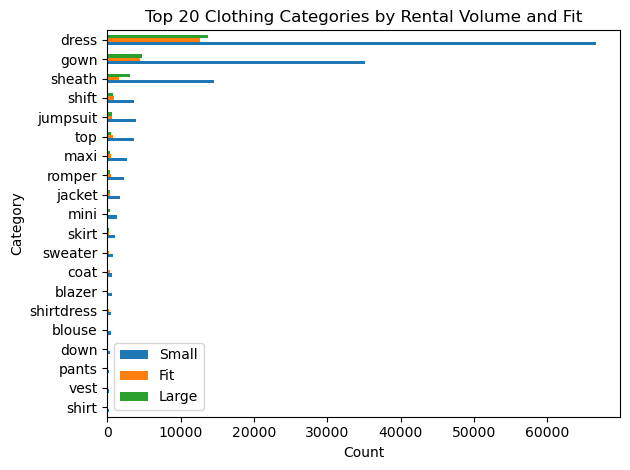

<Figure size 1200x1000 with 0 Axes>

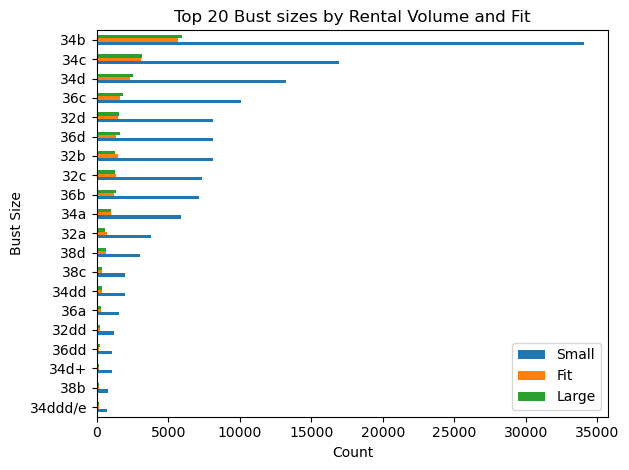

<Figure size 1500x800 with 0 Axes>

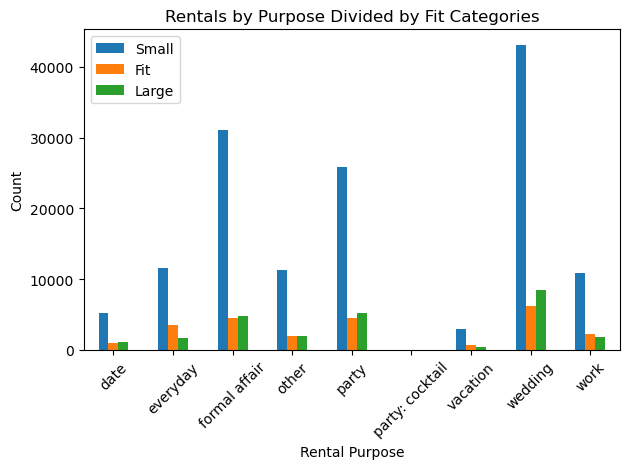

In [15]:
 # Body Type Divided by Fit Categories
plt.figure(figsize=(15, 8))
purpose_fit = pd.crosstab(data['body_type'], data['fit'])
purpose_fit.plot(kind='bar', stacked=False)
plt.title('Body Type Divided by Fit Categories')
plt.xlabel('Body Type')
plt.ylabel('Count')
plt.legend(['Small', 'Fit', 'Large'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 20 Clothing Categories by Rental Volume and Fit
plt.figure(figsize=(12, 10))
category_counts = pd.crosstab(data['category'], data['fit'])
top_20_categories = category_counts.sum(axis=1).sort_values(ascending=True).tail(20).index
category_counts.loc[top_20_categories].plot(kind='barh', stacked=False)
plt.title('Top 20 Clothing Categories by Rental Volume and Fit')
plt.xlabel('Count')
plt.ylabel('Category')
plt.legend(['Small', 'Fit', 'Large'])
plt.tight_layout()
plt.show()


# Top 20 Bust sizes by Rental Volume and Fit
plt.figure(figsize=(12, 10))
category_counts = pd.crosstab(data['bust_size'], data['fit'])
top_20_categories = category_counts.sum(axis=1).sort_values(ascending=True).tail(20).index
category_counts.loc[top_20_categories].plot(kind='barh', stacked=False)
plt.title('Top 20 Bust sizes by Rental Volume and Fit')
plt.xlabel('Count')
plt.ylabel('Bust Size')
plt.legend(['Small', 'Fit', 'Large'])
plt.tight_layout()
plt.show()

# Rentals by Purpose divided by Fit Categories
plt.figure(figsize=(15, 8))
purpose_fit = pd.crosstab(data['rented_for'], data['fit'])
purpose_fit.plot(kind='bar', stacked=False)
plt.title('Rentals by Purpose Divided by Fit Categories')
plt.xlabel('Rental Purpose')
plt.ylabel('Count')
plt.legend(['Small', 'Fit', 'Large'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##1.3 Converting data type

In [16]:
def bust_size_to_numeric(bust_size):
    """
    Function to convert bust size string to numeric, keeping NaN as NaN.

    Args:
        bust_size: The bust size string

    Returns:
        float or NaN: The numeric bust size or NaN if input is NaN or invalid.
    """

    if pd.isna(bust_size):
        return np.nan

    try:
        band_size = int(re.search(r'\d+', bust_size).group())
        cup_part = re.sub(r'\d+', '', bust_size).lower()

        cup_mapping = {
            'aa': 0.5, 'a': 1, 'b': 2, 'c': 3, 'd': 4,
            'dd': 5, 'ddd': 6, 'e': 5, 'f': 6,
            'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11
        }
        if '+' in cup_part:
            cup_part = cup_part.replace('+', '')
            cup_value = cup_mapping.get(cup_part, 0) + 0.5
        elif '/' in cup_part:
            cup_part = cup_part.split('/')[0]
            cup_value = cup_mapping.get(cup_part, 0)
        else:
            cup_value = cup_mapping.get(cup_part, 0)

        return band_size + cup_value

    except (AttributeError, ValueError):
        return np.nan

In [17]:
def rented_for_to_numeric(rented_for):
    """
    Function to convert rented for string to numeric, keeping NaN as NaN.

    Args:
        rented_for: The rented for string

    Returns:
        float or NaN: The numeric rented for or NaN if input is NaN or invalid.
    """
    if pd.isna(rented_for):
        return np.nan

    rented_for_mapping = {
        'vacation': 1,
        'other': 2,
        'party': 3,
        'formal affair': 4,
        'wedding': 5,
        'date': 6,
        'everyday': 7,
        'work': 8,
        'party: cocktail': 9
    }

    return rented_for_mapping.get(rented_for, np.nan)

In [18]:
def body_type_to_numeric(body_type):
    """
    Function to convert body type string to numeric, keeping NaN as NaN.

    Args:
        body_type: The body type string

    Returns:
        float or NaN: The numeric body type or NaN if input is NaN or invalid.
    """
    if pd.isna(body_type):
        return np.nan

    body_type_mapping = {
        'hourglass': 1,
        'straight & narrow': 2,
        'pear': 3,
        'athletic': 4,
        'full bust': 5,
        'petite': 6,
        'apple': 7
    }

    return body_type_mapping.get(body_type, np.nan)

In [19]:
def category_to_numeric(category):
    """
    Function to convert category string to numeric, keeping NaN as NaN.

    Args:
        category: The category string

    Returns:
        float or NaN: The numeric category or NaN if input is NaN or invalid.
    """

    if pd.isna(category):
        return np.nan

    category_mapping = {
        'romper': 1, 'gown': 2, 'sheath': 3, 'dress': 4, 'leggings': 5,
        'top': 6, 'jumpsuit': 7, 'sweater': 8, 'jacket': 9, 'shirtdress': 10,
        'maxi': 11, 'shift': 12, 'pants': 13, 'shirt': 14, 'mini': 15,
        'skirt': 16, 'pullover': 17, 'blouse': 18, 'suit': 19, 'coat': 20,
        'trench': 21, 'bomber': 22, 'cape': 23, 'blazer': 24, 'vest': 25,
        'duster': 26, 'ballgown': 27, 'tank': 28, 'poncho': 29, 'frock': 30,
        'tunic': 31, 'cardigan': 32, 'culottes': 33, 'down': 34, 'trouser': 35,
        'midi': 36, 'pant': 37, 'legging': 38, 'print': 39, 'knit': 40,
        'culotte': 41, 'sweatshirt': 42, 'peacoat': 43, 'kaftan': 44,
        'overalls': 45, 'jogger': 46, 'tee': 47, 'combo': 48, 'henley': 49,
        'cami': 50, 'blouson': 51, 'turtleneck': 52, 'trousers': 53,
        'overcoat': 54, 'hoodie': 55, 't-shirt': 56, 'caftan': 57,
        'tight': 58, 'kimono': 59, 'for': 60, 'crewneck': 61, 'skirts': 62,
        'parka': 63, 'buttondown': 64, 'skort': 65, 'sweatershirt': 66,
        'sweatpants': 67, 'jeans': 68
    }

    return category_mapping.get(category, np.nan)

In [20]:
# Convert all categorical features to numberical features
print('Unique values for bust_size before conversion:',data['bust_size'].unique())
print()
data['bust_size'] = data['bust_size'].apply(bust_size_to_numeric)
print('Unique values for bust_size after conversion:',data['bust_size'].unique())
print()
print('Unique values for rented_for before conversion: ',data['rented_for'].unique())
print()
data['rented_for'] = data['rented_for'].apply(rented_for_to_numeric)
print('Unique values for rented_for after conversion:',data['rented_for'].unique())
print()
print('Unique values for body_type before conversion:',data['body_type'].unique())
print()
data['body_type'] = data['body_type'].apply(body_type_to_numeric)
print('Unique values for body_type after conversion:',data['body_type'].unique())
print()
print('Unique values for category before conversion:',data['category'].unique())
print()
data['category'] = data['category'].apply(category_to_numeric)
print('Unique values for category after conversion:',data['category'].unique())

Unique values for bust_size before conversion: ['34d' '34b' '34c' '32b' '34d+' '36d' '36a' '32d+' '36c' '32c' '32dd'
 '30dd' '32d' '36b' '34a' '34dd' '40ddd/e' '32a' '38d+' '38c' '34ddd/e'
 '38a' '38b' '38d' '36ddd/e' '38dd' '38f' '42dd' '36dd' '40g' '40dd' '28f'
 '30ddd/e' '32ddd/e' '28b' '36d+' '40d' '28dd' '34f' '42c' '30d' '30b'
 '42d' '34aa' '32aa' '36f' '28c' '40b' '36aa' '34g' '32f' '42ddd/e' '40c'
 '28g' '28aa' '36g' '30a' '44ddd/e' '30c' '30aa' '44dd' '32i' '32g' '30g'
 '38h' '30h' '34j' '38ddd/e' '32h' '28a' '44d' '40h' '38g' '34h' '36j'
 '40f' '36h' '28ddd/e' '44f' '34i' '30f' '36i' '30i' '28h' '42b' '42j'
 '32j' '46c' '48d' '38aa' '38i' '48dd' '28d' '28i' '46ddd/e' '42g' '44c'
 '42f' '40j' '38j' '46f' '44b' '44g' '42h' '40i' '44h']

Unique values for bust_size after conversion: [38.  36.  37.  34.  38.5 40.  36.5 39.  35.  46.  33.  42.5 41.  42.
 43.  44.  47.  45.  30.  40.5 32.  34.5 32.5 31.  48.  28.5 50.  30.5
 49.  29.  52.  53.  51. ]

Unique values for rented_for b

In [21]:
# Additional date and string specific conversions
data['review_date'] = pd.to_datetime(data['review_date'])
data['weight'] = data.weight.str.replace('lbs', '')
data['weight'] = data['weight'].astype('float64')

# Drop columns that are not used
data = data.drop(['review_text','review_summary','review_date'], axis=1)

In [22]:
def height_to_cm(height):
    """
    Function to convert height from feet and inch representation to centimeters, keeping NaN as NaN.

    Args:
        height: The height string

    Returns:
        float or NaN: The numeric height in centimeters or NaN if input is NaN or invalid.
    """
    # Split the height string like '5' 2" into feet and inches
    feet, inches = height.split("'")
    inches = inches.replace('"', '').strip()  # Remove the inch symbol and strip whitespace
    feet = int(feet.strip())  # Convert feet to integer
    inches = int(inches.strip())  # Convert inches to integer

    # Convert to cm
    height_cm = (feet * 30.48) + (inches * 2.54)
    return height_cm

# Example DataFrame
data['height'] = data['height'].apply(height_to_cm)


In [23]:
# Convert fit column data into numerical values
data_cor = data.replace({'fit': 2, 'small': 1, 'large': 3})

/var/folders/nt/t2rcl5mn1kl1k_dtq25_f1900000gn/T/ipykernel_31829/1543989365.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cor = data.replace({'fit': 2, 'small': 1, 'large': 3})


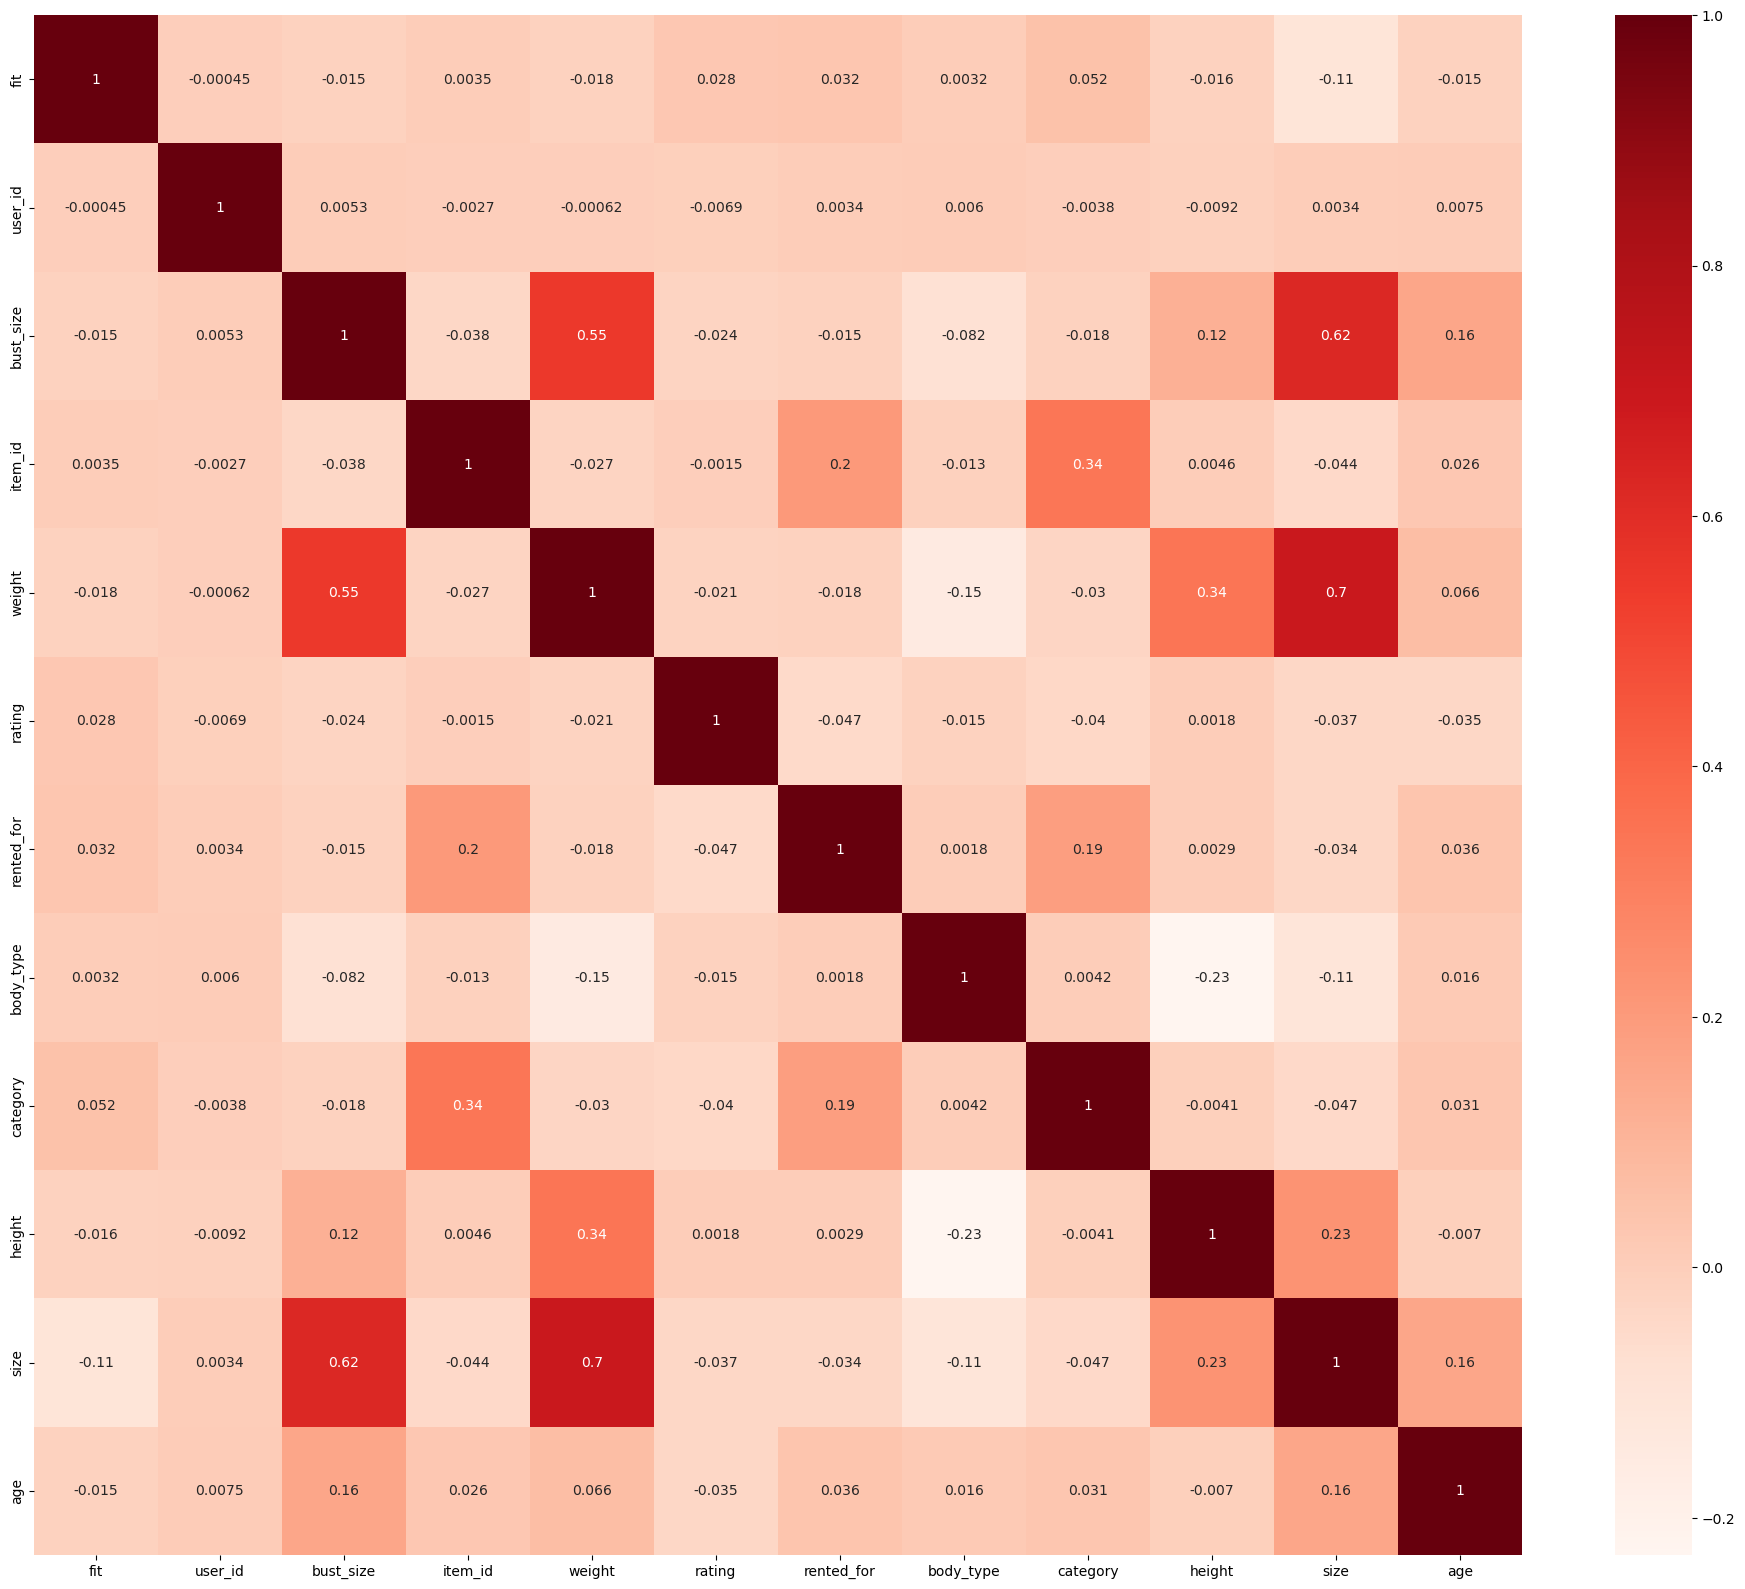

In [24]:
# Computing the Pearson's Correlation Matrix for all numerical features
cor = data_cor.corr(method ='pearson')

plt.figure(figsize=(24,20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [25]:
### Filter the outliers
print('Number of entries with age above 100:',np.sum([data['age'].unique()>=100]))
data = data[data.age <= 100]
print('Number of entries with size below 22:',np.sum([data['size'].unique()<=22]))
data = data[data['size'] <= 22]

Number of entries with age above 100: 8
Number of entries with size below 22: 23


In [26]:
# Reseting row labels after filtering out outliers
data.reset_index(drop=True,inplace= True)

Correlation, distribution and box plot


Dataset Basic Parameters:
                           Value
Number of Transactions  171128.0
Number of Users          93484.0
Number of Items           5695.0
Small Percentage             0.0
Fit Percentage               0.0
Large Percentage             0.0


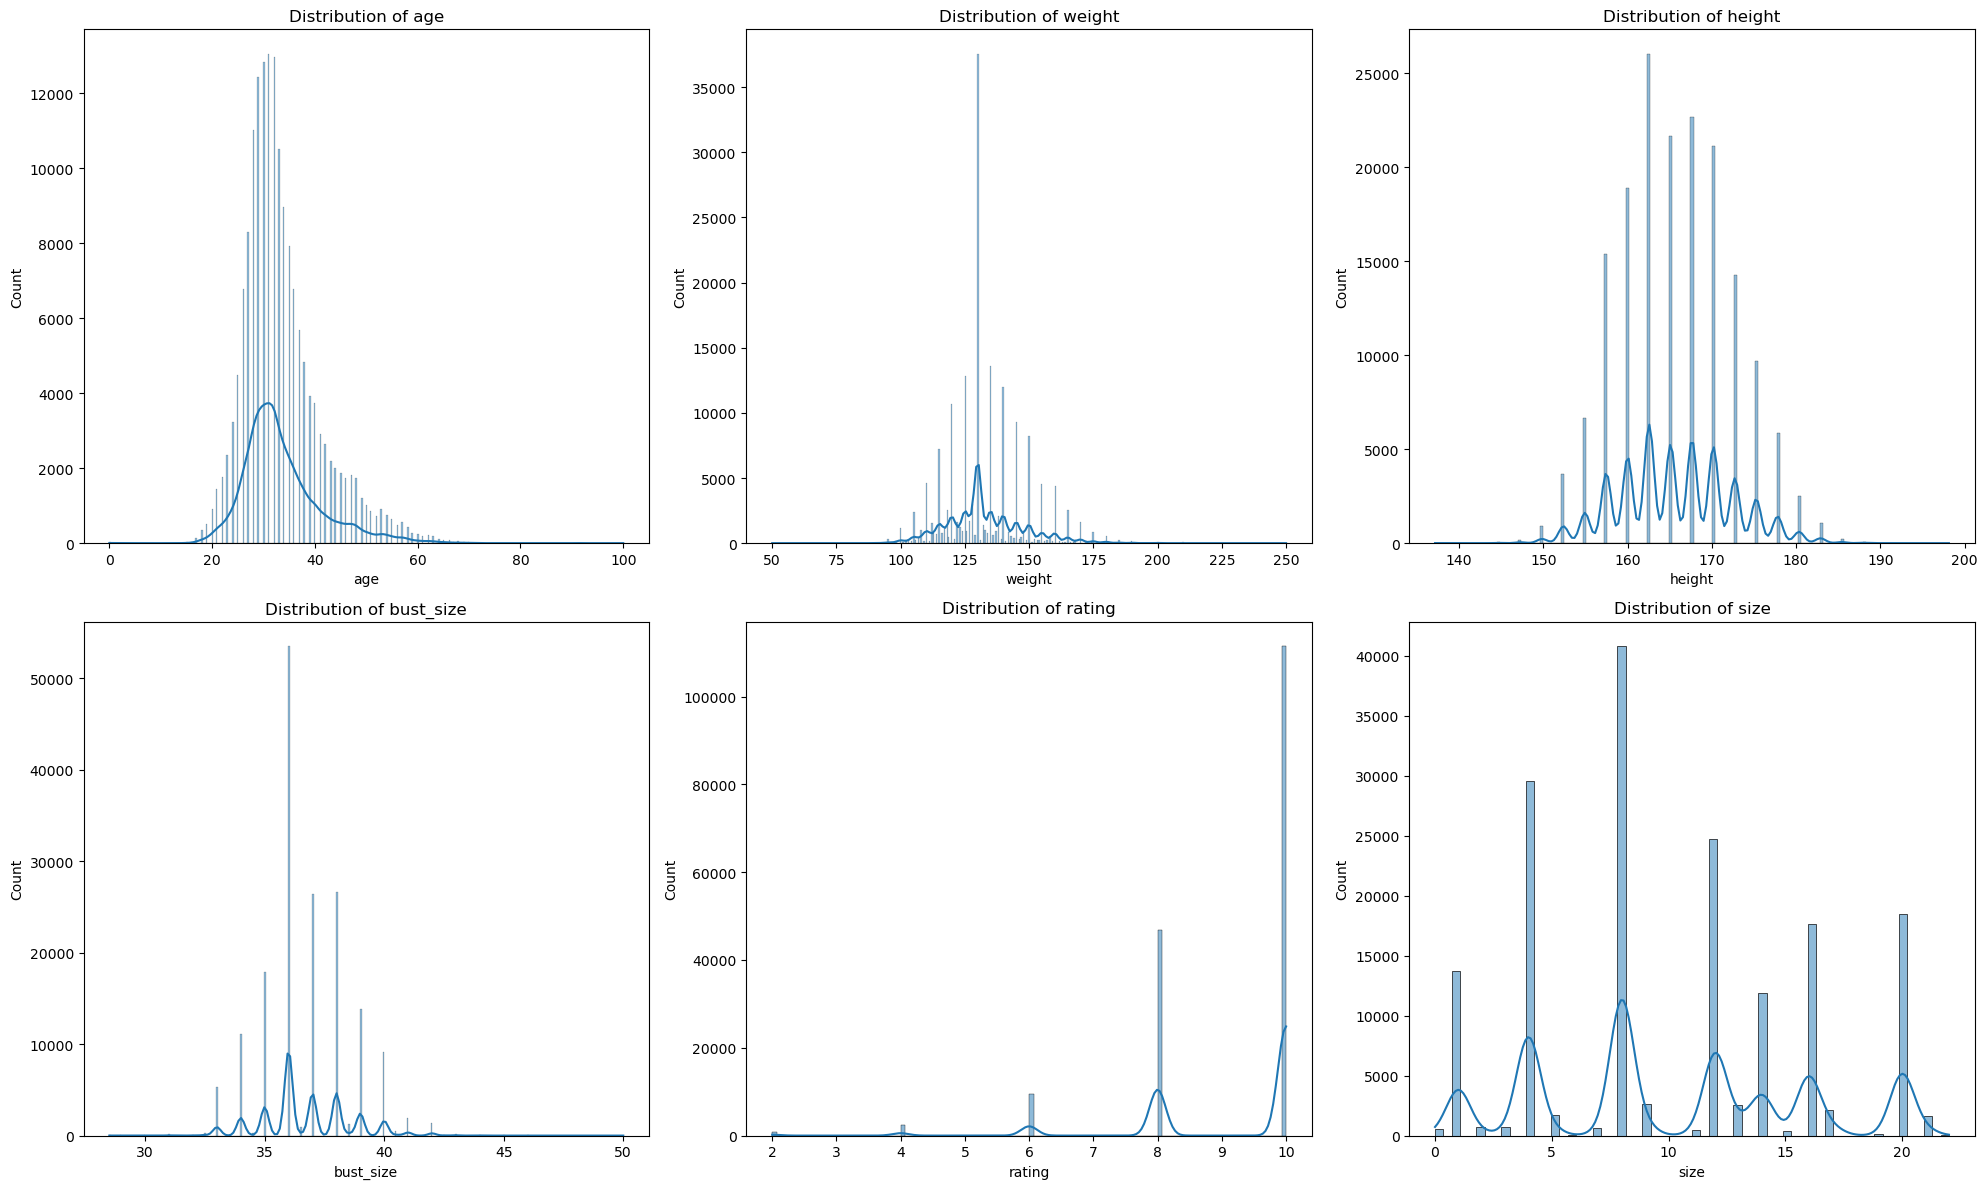

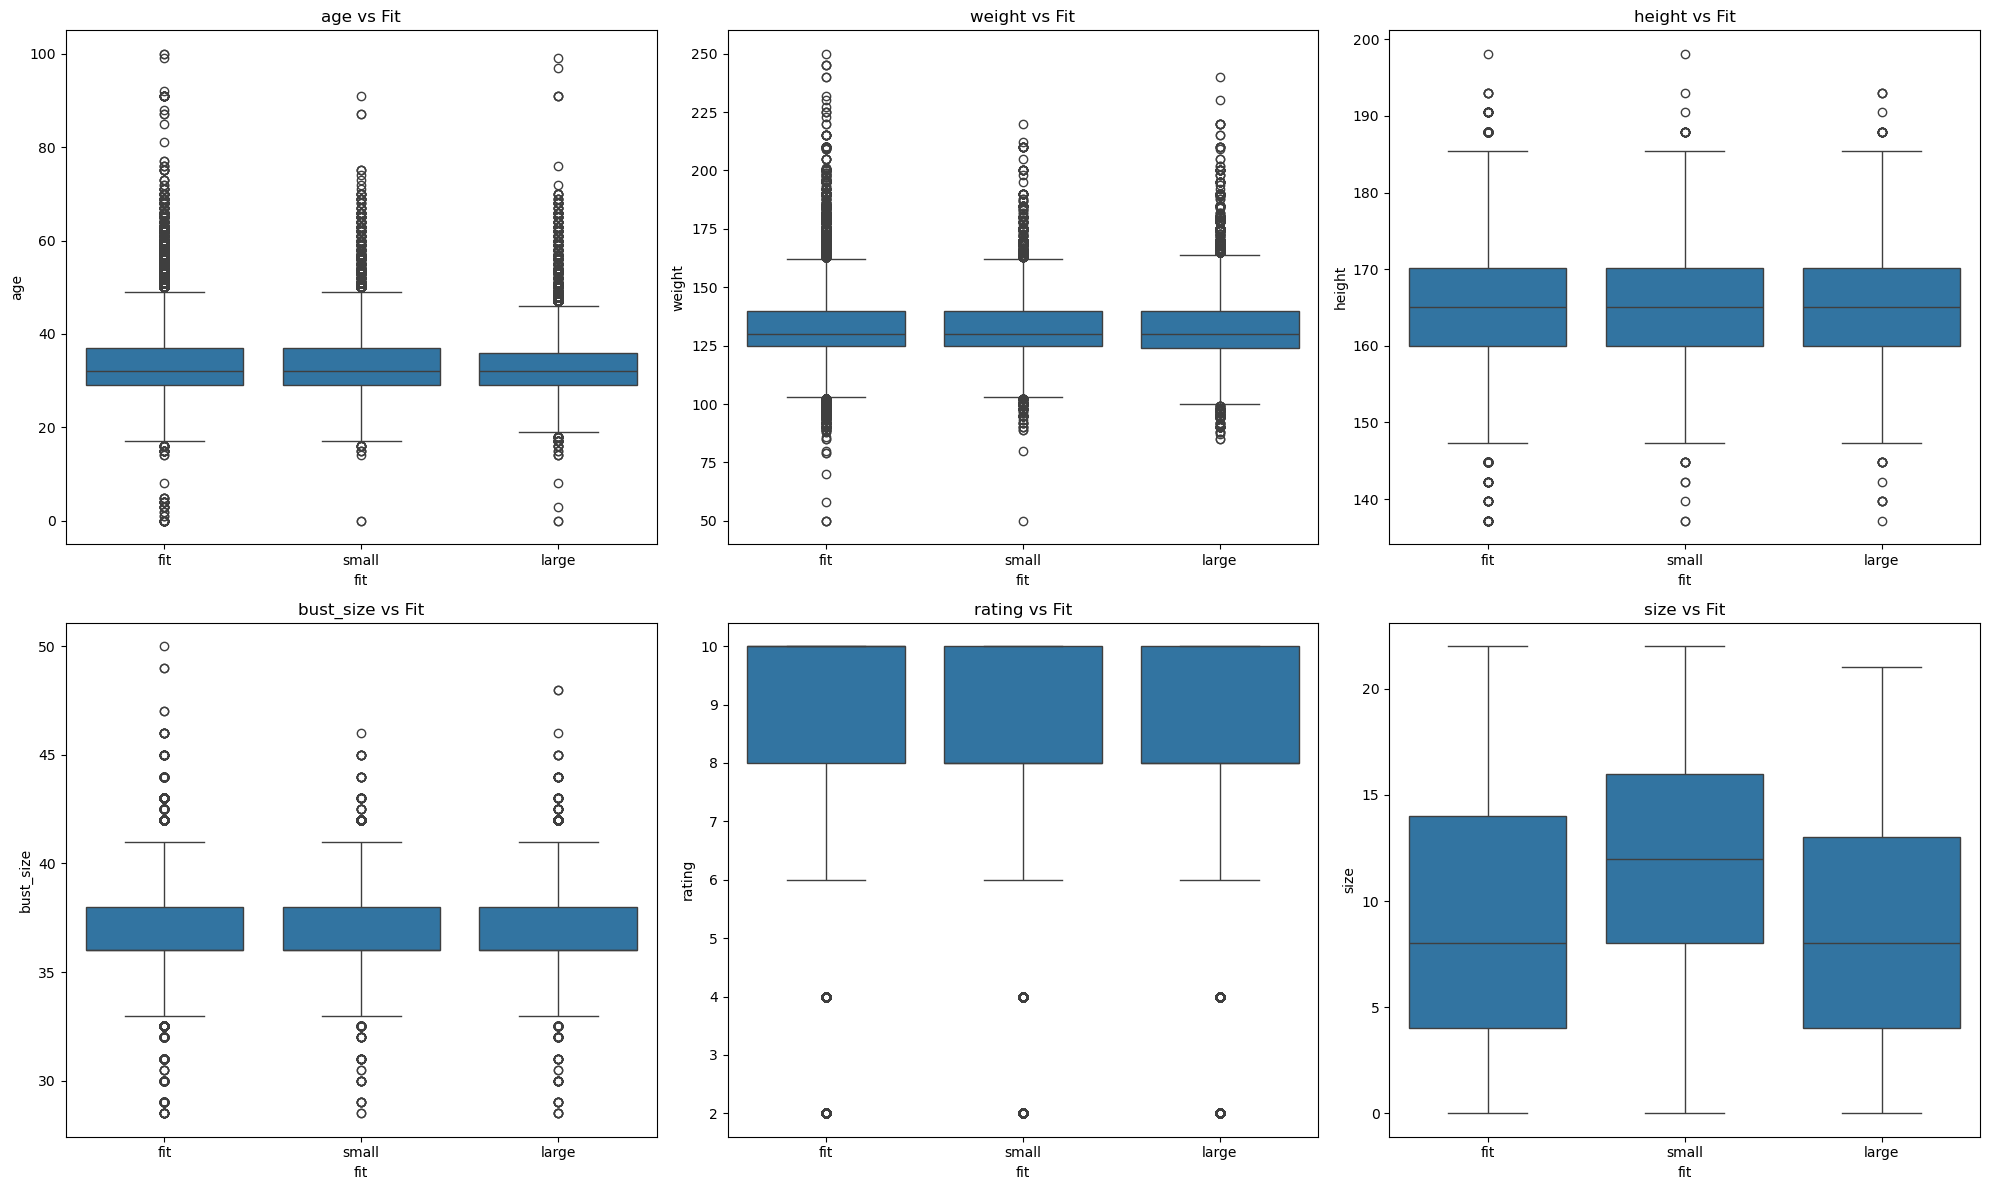

In [ ]:
def create_eda_analysis(data):
    """
    Create comprehensive EDA visualizations and tables for the cleaned dataset.
    """

    # Dataset Basic Parameters Table
    basic_params = {
        'Number of Transactions': len(data),
        'Number of Users': data['user_id'].nunique(),
        'Number of Items': data['item_id'].nunique(),
        'Small Percentage': (data['fit'] == 0).mean() * 100,
        'Fit Percentage': (data['fit'] == 1).mean() * 100,
        'Large Percentage': (data['fit'] == 2).mean() * 100
    }

    params_df = pd.DataFrame.from_dict(basic_params, orient='index', columns=['Value'])
    print("\nDataset Basic Parameters:")
    print(params_df)

    # Standard numerical distributions
    numerical_features = ['age', 'weight', 'height', 'bust_size', 'rating', 'size']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    for idx, feature in enumerate(numerical_features):
        row = idx // 3
        col = idx % 3
        sns.histplot(data=data, x=feature, ax=axes[row, col], kde=True)
        axes[row, col].set_title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

    # Box plots for numerical features by fit
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    for idx, feature in enumerate(numerical_features):
        row = idx // 3
        col = idx % 3
        sns.boxplot(data=data, x='fit', y=feature, ax=axes[row, col])
        axes[row, col].set_title(f'{feature} vs Fit')
    plt.tight_layout()
    plt.show()

# Call the function
create_eda_analysis(data)